In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Set the seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# Define the path to your dataset
data_dir = "/content/leaf-dataset"
classes = os.listdir(data_dir)

In [4]:
# Define the image size
img_size = (128, 128)

In [5]:
# Load and preprocess the data
X = []
y = []

In [6]:
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_dir):
        # Check if the file is an image (e.g., with a .jpg or .png extension)
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
            img_path = os.path.join(class_dir, img_file)
            try:
                img = Image.open(img_path)
                img = img.resize(img_size)
                img = np.array(img) / 255.0  # Normalize the pixel values
                X.append(img)
                y.append(class_name)
            except OSError as e:
                # Handle the error, for example, by printing a message and removing the problematic file
                print(f"Error processing {img_file}: {str(e)}")
                os.remove(img_path)  # Remove the problematic file

Error processing IMG_20201003_171134.jpg: image file is truncated (14 bytes not processed)
Error processing IMG_20201003_171129.jpg: image file is truncated (58 bytes not processed)
Error processing IMG_20201003_171145.jpg: image file is truncated (17 bytes not processed)
Error processing IMG_20201003_171112.jpg: image file is truncated (61 bytes not processed)
Error processing IMG_20201003_171103.jpg: image file is truncated (12 bytes not processed)


In [7]:
X = np.array(X)
y = np.array(y)

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


In [9]:
# Encode class labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [10]:
# Models to compare
models = {
    "CNN": keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), input_shape=(img_size[0], img_size[1], 3), activation='relu'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(len(classes), activation='softmax')
    ]),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=seed),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=seed)
}


In [11]:
# Train and evaluate each model
accuracies = {}

for model_name, model in models.items():
    if model_name == "CNN":
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train_encoded, epochs=15, batch_size=32, validation_split=0.2)
        test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
        accuracies[model_name] = test_accuracy
    else:
        if model_name == "Random Forest":
            vectorizer = CountVectorizer()
            X_train_rf = vectorizer.fit_transform(y_train)
            X_test_rf = vectorizer.transform(y_test)
        elif model_name == "SVM":
            X_train_svm = X_train.reshape(X_train.shape[0], -1)
            X_test_svm = X_test.reshape(X_test.shape[0], -1)
        elif model_name == "KNN":
            X_train_knn = X_train.reshape(X_train.shape[0], -1)
            X_test_knn = X_test.reshape(X_test.shape[0], -1)
        else:
            X_train_mlp = X_train.reshape(X_train.shape[0], -1)
            X_test_mlp = X_test.reshape(X_test.shape[0], -1)

        model.fit(X_train_rf if model_name == "Random Forest" else
                  X_train_svm if model_name == "SVM" else
                  X_train_knn if model_name == "KNN" else X_train_mlp, y_train_encoded)

        if model_name == "Random Forest":
            test_pred = model.predict(X_test_rf)
        elif model_name == "SVM":
            test_pred = model.predict(X_test_svm)
        elif model_name == "KNN":
            test_pred = model.predict(X_test_knn)
        else:
            test_pred = model.predict(X_test_mlp)

        test_accuracy = accuracy_score(y_test_encoded, test_pred)
        accuracies[model_name] = test_accuracy

Epoch 1/15
34/34 [==============================] - 28s 785ms/step - loss: 2.7330 - accuracy: 0.1409 - val_loss: 2.5183 - val_accuracy: 0.1673
Epoch 2/15
34/34 [==============================] - 26s 776ms/step - loss: 2.1398 - accuracy: 0.3190 - val_loss: 2.1552 - val_accuracy: 0.3123
Epoch 3/15
34/34 [==============================] - 27s 797ms/step - loss: 1.6245 - accuracy: 0.4953 - val_loss: 1.7245 - val_accuracy: 0.4721
Epoch 4/15
34/34 [==============================] - 26s 776ms/step - loss: 1.1228 - accuracy: 0.6511 - val_loss: 1.7093 - val_accuracy: 0.4796
Epoch 5/15
34/34 [==============================] - 26s 782ms/step - loss: 0.8052 - accuracy: 0.7547 - val_loss: 1.6624 - val_accuracy: 0.5353
Epoch 6/15
34/34 [==============================] - 26s 778ms/step - loss: 0.6409 - accuracy: 0.8218 - val_loss: 1.7490 - val_accuracy: 0.4870
Epoch 7/15
34/34 [==============================] - 26s 778ms/step - loss: 0.3711 - accuracy: 0.9002 - val_loss: 1.9775 - val_accuracy: 0.4870

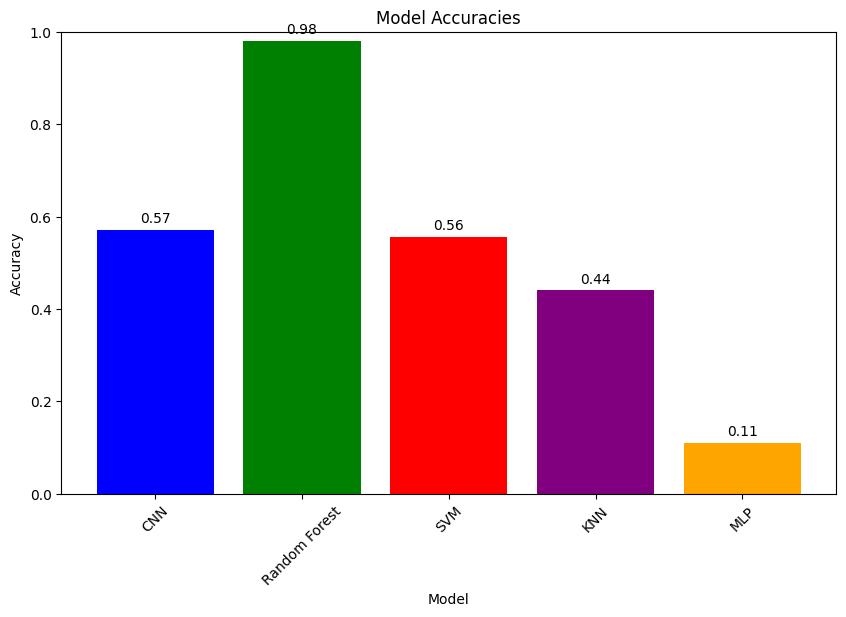

In [12]:
# Specify custom colors for the bars
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plot the accuracies with custom colors
plt.figure(figsize=(10, 6))
bars = plt.bar(accuracies.keys(), accuracies.values(), color=colors)
plt.title("Model Accuracies")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()


11/11 [==============================] - 2s 160ms/step


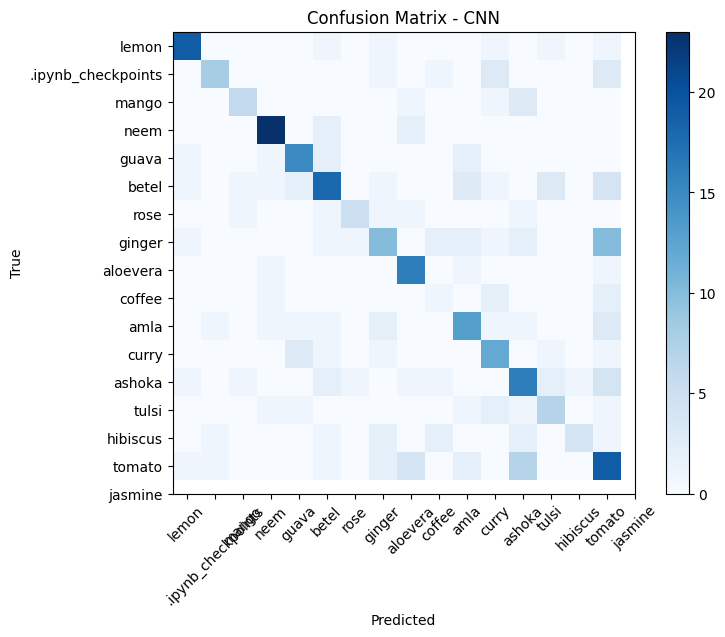

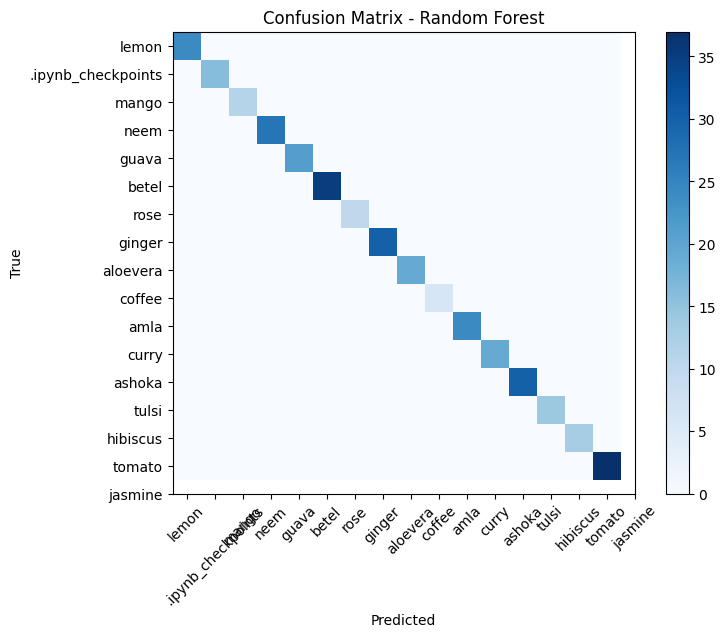

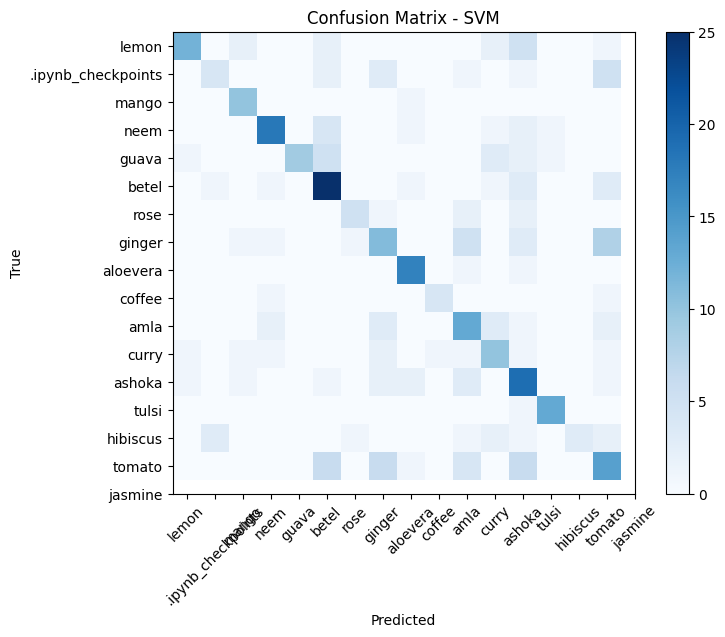

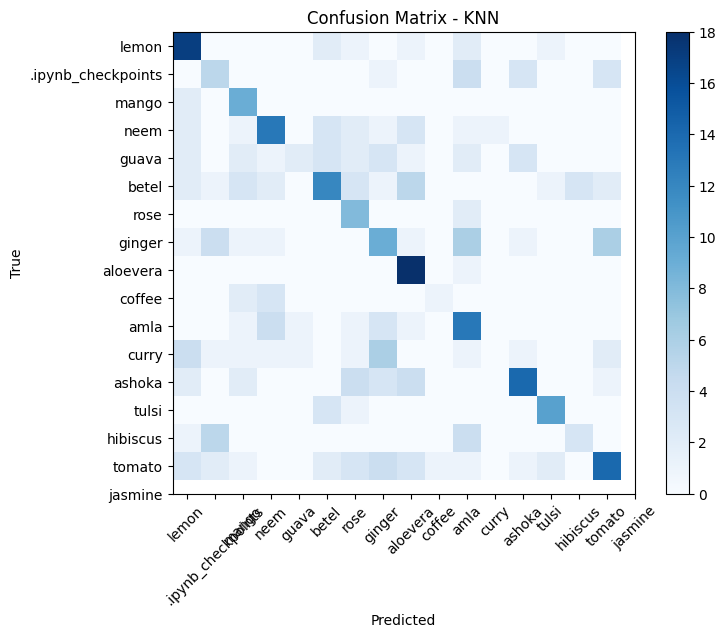

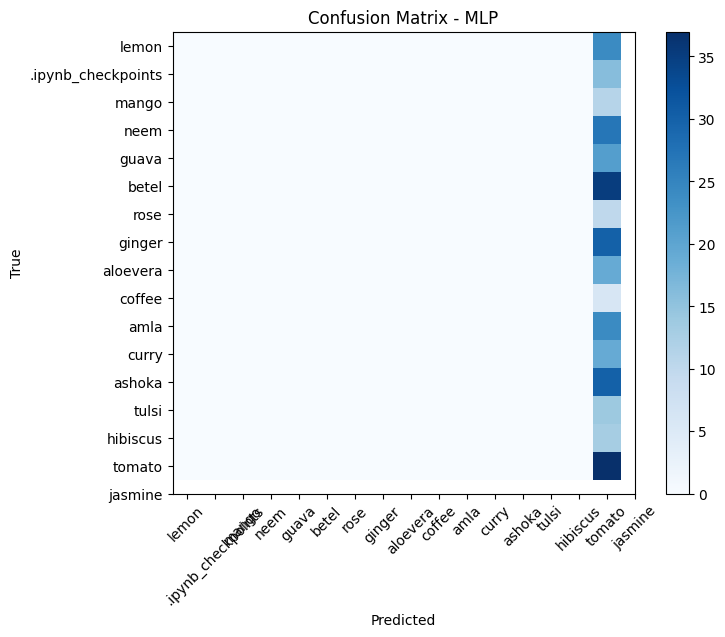

In [13]:
# Display confusion matrices for all models
for model_name, model in models.items():
    if model_name == "CNN":
        y_pred_classes = np.argmax(model.predict(X_test), axis=1)
    else:
        if model_name == "Random Forest":
            test_pred = model.predict(X_test_rf)
        elif model_name == "SVM":
            test_pred = model.predict(X_test_svm)
        elif model_name == "KNN":
            test_pred = model.predict(X_test_knn)
        else:
            test_pred = model.predict(X_test_mlp)

        y_pred_classes = test_pred

    conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes)

    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [14]:
# Create a CNN model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), input_shape=(img_size[0], img_size[1], 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(len(classes), activation='softmax')
])

In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [16]:
# Train the CNN model
model.fit(X_train, y_train_encoded, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
34/34 [==============================] - 27s 779ms/step - loss: 3.0398 - accuracy: 0.1017 - val_loss: 2.6760 - val_accuracy: 0.2045
Epoch 2/15
34/34 [==============================] - 26s 774ms/step - loss: 2.5454 - accuracy: 0.1754 - val_loss: 2.4408 - val_accuracy: 0.2379
Epoch 3/15
34/34 [==============================] - 25s 738ms/step - loss: 2.1470 - accuracy: 0.3358 - val_loss: 2.0525 - val_accuracy: 0.3717
Epoch 4/15
34/34 [==============================] - 30s 897ms/step - loss: 1.7436 - accuracy: 0.4375 - val_loss: 1.8699 - val_accuracy: 0.4238
Epoch 5/15
34/34 [==============================] - 25s 750ms/step - loss: 1.3811 - accuracy: 0.5634 - val_loss: 1.7684 - val_accuracy: 0.4572
Epoch 6/15
34/34 [==============================] - 26s 780ms/step - loss: 1.1939 - accuracy: 0.6185 - val_loss: 1.8641 - val_accuracy: 0.4387
Epoch 7/15
34/34 [==============================] - 25s 747ms/step - loss: 0.8955 - accuracy: 0.7183 - val_loss: 1.8264 - val_accuracy: 0.4758

In [17]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test accuracy: {test_accuracy:.4f}")

11/11 [==============================] - 3s 240ms/step - loss: 2.0084 - accuracy: 0.5655
Test accuracy: 0.5655


In [18]:
# Make predictions using the trained model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_names = label_encoder.inverse_transform(y_test_encoded)
y_pred_names = label_encoder.inverse_transform(y_pred_classes)

11/11 [==============================] - 2s 188ms/step


In [19]:
# Print a classification report and confusion matrix
print(classification_report(y_test_names, y_pred_names))
conf_matrix = confusion_matrix(y_test_names, y_pred_names)

              precision    recall  f1-score   support

    aloevera       0.77      0.83      0.80        24
        amla       0.54      0.44      0.48        16
      ashoka       0.73      1.00      0.85        11
       betel       0.70      0.78      0.74        27
      coffee       0.35      0.86      0.49        21
       curry       0.69      0.31      0.43        35
      ginger       0.50      0.40      0.44        10
       guava       0.73      0.27      0.39        30
    hibiscus       0.60      0.79      0.68        19
     jasmine       0.67      0.33      0.44         6
       lemon       0.33      0.29      0.31        24
       mango       0.83      0.53      0.65        19
        neem       0.62      0.43      0.51        30
        rose       0.92      0.79      0.85        14
      tomato       1.00      0.38      0.56        13
       tulsi       0.41      0.73      0.52        37

    accuracy                           0.57       336
   macro avg       0.65   

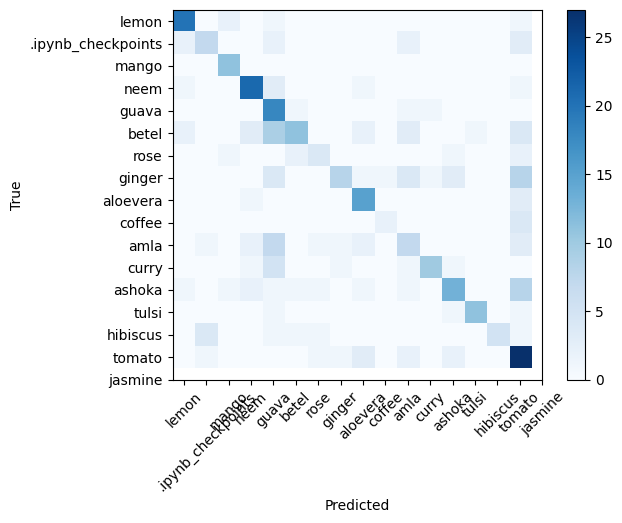

In [20]:
# Display the confusion matrix
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [21]:
# Train a Random Forest classifier for comparison
vectorizer = CountVectorizer()
X_train_rf = vectorizer.fit_transform(y_train)
X_test_rf = vectorizer.transform(y_test)

rf_classifier = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=seed)  # Adjust the number of trees and max depth
rf_classifier.fit(X_train_rf, y_train_encoded)
rf_pred = rf_classifier.predict(X_test_rf)
rf_accuracy = accuracy_score(y_test_encoded, rf_pred)
print(f"Random Forest Test accuracy: {rf_accuracy:.4f}")


Random Forest Test accuracy: 1.0000


In [22]:
# Take a random image as input, display it, and make a prediction
random_image_path = "/content/leaf-dataset/mango/198.jpg"  # Replace with the path to your random image
random_img = Image.open(random_image_path)
random_img = random_img.resize(img_size)
random_img = np.array(random_img) / 255.0  # Normalize the pixel values
random_img = np.expand_dims(random_img, axis=0)  # Add batch dimension

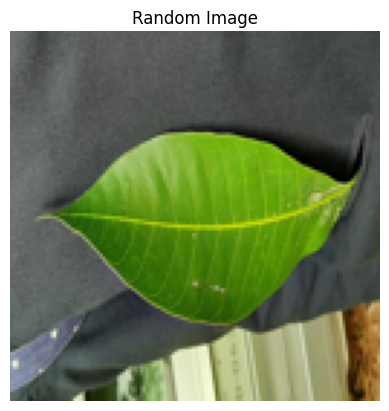

In [23]:
# Display the random image
plt.imshow(random_img[0])
plt.title("Random Image")
plt.axis('off')
plt.show()


In [24]:
# Use the trained model to predict the class of the random image
random_img_prediction = model.predict(random_img)
predicted_class_index = np.argmax(random_img_prediction)
predicted_class_name = label_encoder.inverse_transform([predicted_class_index])[0]

1/1 [==============================] - 0s 29ms/step


In [25]:
print(f"The predicted class for the random image is: {predicted_class_name}")

The predicted class for the random image is: mango
